## Organoid simulation (credit: Mason Hargrave, modif: Lucas Seninge)

This notebook is based on Mason's method to simulate organoids. It uses a stochastic model to determine which neurons will fire at t+1 based on neurons firing at t. See Mason's model description.

In [1]:
# Import modules
import numpy as np
np.random.seed(42)

Added inhibitory neurons to the total population: User can pick a proportion of inhibitory neurons which will be randomly picked in the neuron vector.

In the case of inhibitory neurons, neuron  $j$ firing at time  $t$ will cause neuron  $i$ to NOT fire at time  $t+1$. So we take the inverse of this probability so that in the product of $(1-p_{i,j})$ , inhibitory neurons firing will decrease the probability of neuron $i$ firing.

This simple model may need refinement as the biology of neuron inhibition is slightly different.

Also, we added a refractory period: if a neuron was firing at $t$, it won't be able to fire at $t+1$, no matter what the probability would have been.

## Model Initialization

In [2]:
# Simulation parameters
# Number of neurons
neurons = 1000

# Proportion of inhibitory neurons in the neuron population
prop_inhib = 0.2
# Generates a boolean array determining which neurons are inhibitory.
inhib_idx = np.random.choice(neurons, int(prop_inhib*neurons))
inhib = np.zeros(neurons, dtype=np.bool)
inhib[inhib_idx] = True

# Probability matrix - initialize randomly
probability_matrix = np.random.rand(neurons,neurons)

# Neurons state - initialize randomly
initial_state = np.random.randint(2, size=neurons, dtype=np.bool)
# Number of iterations - discret time steps (change to actual time?)
time = 1000

In [3]:
# Preprocessing
# Scale-down probabilities by using index distance as a proxy for real distance
for (i,j) in np.ndindex(np.shape(probability_matrix)):
    distance = min(abs(i-j),neurons-abs(i-j)) #calculate toroidal distance (implementing periodic boundary conditions)
    # Avoid self firing for now
    if distance == 0:
        probability_matrix[i,j] = 0
    else:
        probability_matrix[i,j] = (1/distance**2) * probability_matrix[i,j]
        
print(probability_matrix)

[[0.         0.13933145 0.15110434 ... 0.06997532 0.05408101 0.51826037]
 [0.59727407 0.         0.26023337 ... 0.05605987 0.05779895 0.11190074]
 [0.13945505 0.16603431 0.         ... 0.03560228 0.00526883 0.0896877 ]
 ...
 [0.07675609 0.03555113 0.03793577 ... 0.         0.80748436 0.22270563]
 [0.22485625 0.08872883 0.00820776 ... 0.20451861 0.         0.57739499]
 [0.62189669 0.1909329  0.03805991 ... 0.21176121 0.34004073 0.        ]]


## Optimized version of next_state

In [4]:
def next_state(neurons, probability_matrix, previous_state):
    """
    Get new state t+1 of active/inactive neurons by using probabilities of firing.
    
    Args:
        neurons (int): number of neurons to be simulated.
        probability_matrix (np.array): probability of neuron j firing at t causing neuron i to fire at t+1.
        previous_state (np.array): vector of neuron states at t .
        
    Returns:
        next_state (np.array): vector of neuron states at t+1.
    """
    # Probability that cell j will NOT affect cell i.
    # Restrict attention to cells that are firing.
    anti_probability_matrix = 1 - probability_matrix[:,previous_state]
    # Take product over the two cell types separately.
    # Use indexing instead of masked arrays because faster.
    inh_prod = np.prod(anti_probability_matrix[:,inhib[previous_state]], axis=1)
    exc_prod = np.prod(anti_probability_matrix[:,~inhib[previous_state]], axis=1)
    expectation_values = (1 - exc_prod) * inh_prod
    
    return (np.random.random(neurons) < expectation_values) & (previous_state==0)

In [5]:
%%time
states= np.zeros((time+1, neurons), dtype=np.bool)
states[0,:] = initial_state
for t in range(time):
    states[t+1,:] = next_state(neurons, probability_matrix, states[t,:])

CPU times: user 1.22 s, sys: 14.4 ms, total: 1.24 s
Wall time: 1.24 s


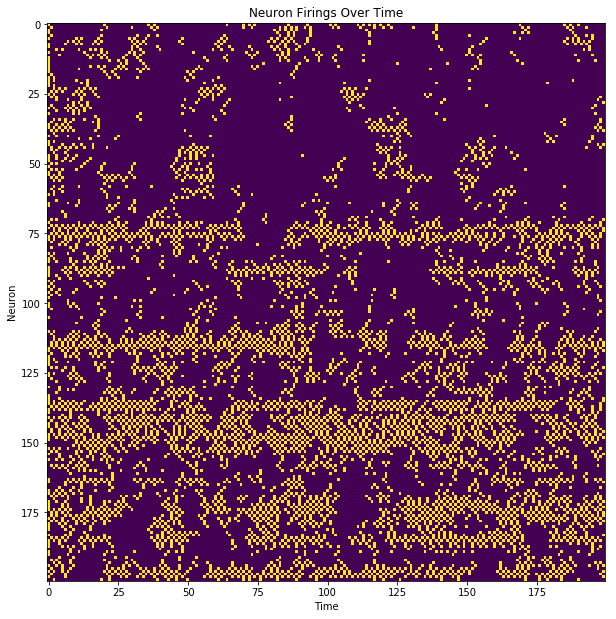

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.imshow(states.T[:200,:200])
plt.xlabel("Time")
plt.ylabel("Neuron")
plt.title("Neuron Firings Over Time")
plt.savefig('my-version.png')